In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.spatial import ConvexHull, convex_hull_plot_2d 

from scipy.stats import entropy
from Bio import SeqIO

## Prepare data:

In [2]:
# Natural sequences
merge_ds = pd.read_excel('./Taxonomy_and_convex_hull/data/20210908_natural_with_taxonomy.xls').iloc[:,1:]
merge_ds.shape

(7865, 19)

In [11]:
# merge the two natural sh3 spreadsheets together 
# note: there should be both the 'In training set' and 'MMD z..' columns 
nat_df = pd.read_excel('data/LibraryNatural_Training5299.xls')

full_nat_df = nat_df.merge( 
    merge_ds,
    on='Sequences_unaligned').reset_index(drop = True)

train_full_nat_df = full_nat_df
train_full_nat_df = train_full_nat_df.drop_duplicates(subset='Sequence_aligned').reset_index(drop = True)

In [12]:
# === functional sequences defined by r.e. > 0.5 ===
func_train_full_nat_df = train_full_nat_df[train_full_nat_df.norm_RE > 0.84158931]
# embeddings
func_train_full_nat_z = func_train_full_nat_df[['MMD_z0', 'MMD_z1', 'MMD_z2']].values

# === nonfunctional sequences definde by r.e. <= 0.5 ===
nonfunc_train_full_nat_df = train_full_nat_df[~(train_full_nat_df.norm_RE > 0.84158931)]
# embeddings
nonfunc_train_full_nat_z = nonfunc_train_full_nat_df[['MMD_z0', 'MMD_z1', 'MMD_z2']].values

func_train_full_nat_z.shape, nonfunc_train_full_nat_z.shape

((132, 3), (5167, 3))

## Plot Functional embedding (Figure 3D):

Here, we are plotting all of the natural training sequences (5299). The pink points are 132 functional sequences (r.e. > 0.84158931) and  5167 remaining embeddings are blue. 

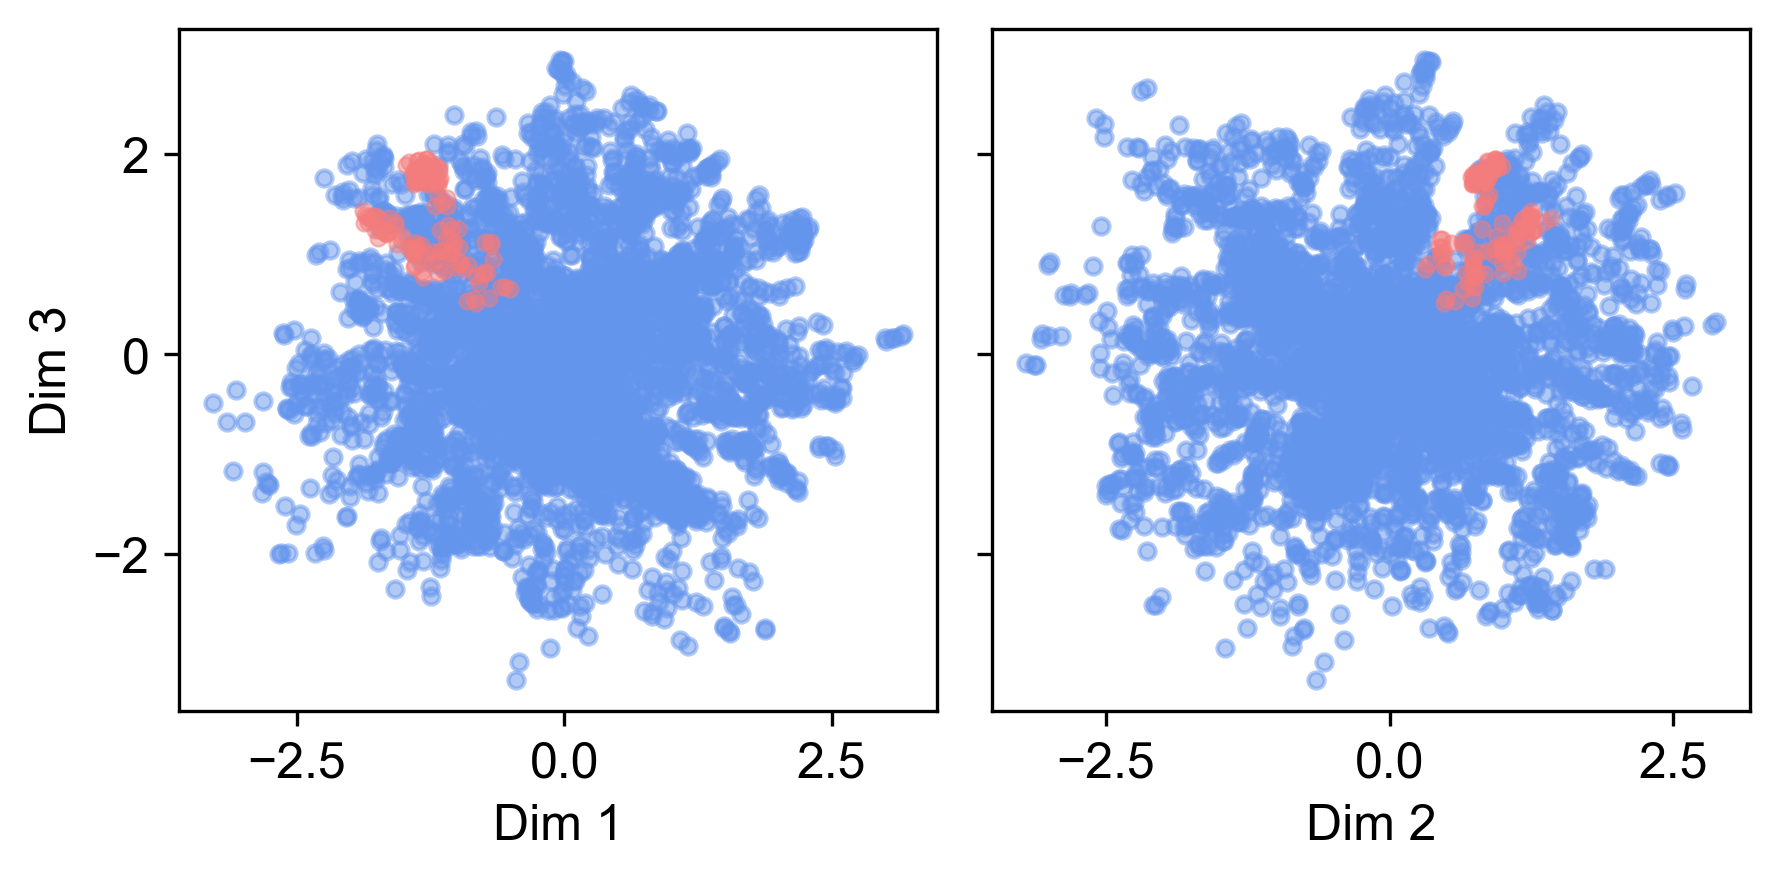

In [13]:
plt.rcParams.update({'font.size': 12})
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams.update({'font.family': 'Arial'})

dsize = 1
size =15
lw=.5
bins = np.linspace(-2.5,2.5,25)

fig, axs = plt.subplots(1, 2, figsize = [6.0,3], sharex="col", sharey="row", dpi=300)


#axs[0, 1].hist(mmd_nat_coord[good_nat,2], bins, orientation='horizontal', color = '#f47b7b')

# functional latent embeddings
axs[0].scatter(nonfunc_train_full_nat_z[:,0], nonfunc_train_full_nat_z[:,2]
               ,s=size, c = 'cornflowerblue',alpha=.5)

axs[0].scatter(func_train_full_nat_z[:,0], func_train_full_nat_z[:,2],
              c = '#f47c7c', linewidth=lw,s = size,alpha=.5 )

# nonfunctional latent embeddings
axs[1].scatter(nonfunc_train_full_nat_z[:,1], nonfunc_train_full_nat_z[:,2]
                                          ,s=size, c = 'cornflowerblue',alpha=.5)
axs[1].scatter(func_train_full_nat_z[:,1], func_train_full_nat_z[:,2],
              c = '#f47c7c', linewidth=lw,s = size,alpha=.5)

# subplot 0 ticks
axs[0].set_xticks([-2.5, 0, 2.5])
axs[0].set_yticks([-2, 0, 2])

# subplot 1 ticks
axs[1].set_xticks([-2.5, 0, 2.5])
axs[1].set_yticks([-2, 0, 2])
    
axs[0].set_xlabel('Dim 1')
axs[0].set_ylabel('Dim 3')
axs[1].set_xlabel('Dim 2')


plt.tight_layout(pad=.8)
#plt.savefig('./figures/Fig3D_natural_func_embeddings.svg', dpi = 300)
plt.show()

## Distances

In [14]:
from scipy.spatial.distance import cdist, squareform

def one_hot_encode_sequences(seqs):
    amino_acids = "ACDEFGHIKLMNPQRSTVWY-"
    aa_to_idx = {aa: i for i, aa in enumerate(amino_acids)}

    one_hot_encoded = np.zeros((len(seqs), len(seqs[0]), len(amino_acids)), dtype=np.uint8)

    for i, seq in enumerate(seqs):
        for j, aa in enumerate(seq):
            one_hot_encoded[i, j, aa_to_idx[aa]] = 1

    return one_hot_encoded.reshape(len(seqs), -1)

In [15]:
seqs = full_nat_df.Sequences
nat_z = train_full_nat_df[['MMD_z0', 'MMD_z1', 'MMD_z2']].values

In [35]:
hamming_no_diag.shape

(28074102,)

In [40]:
# Compute pairwise Hamming distances using one-hot encoding and matrix multiplication
one_hot_seqs = one_hot_encode_sequences(seqs)
pairwise_hamming = len(seqs[0]) - one_hot_seqs @ one_hot_seqs.T

# Compute pairwise Euclidean distances
pairwise_euclidean = cdist(nat_z, nat_z, metric='euclidean')

# Filter out the diagonal elements (distance to self)
hamming_mask = np.eye(pairwise_hamming.shape[0], dtype=bool)
hamming_no_diag = pairwise_hamming[~hamming_mask]
pairwise_euclidean = pairwise_euclidean[~hamming_mask]

In [41]:
pairwise_hamming_uncount_diag = pairwise_hamming.copy()
np.fill_diagonal(pairwise_hamming_uncount_diag, 100)
closest_identity = 1 - np.min(pairwise_hamming_uncount_diag, axis=1)/len(seqs[0])

In [25]:
for num, i in enumerate(seqs.tolist()): # Find index of the wt Sho1 (2vkn)
    if 'DADDA' in i:
        sho1 = i
        sho1_id = num
        break

sho1_identity = one_hot_seqs @ one_hot_seqs[sho1_id] / 59

In [18]:
design_sheet = pd.read_excel('data/20220928_design_sheet.xlsx')
designed_seq = design_sheet['seq'][:11608].tolist()
designed_seq = [i[:16]+i[18:44]+i[45:] for i in designed_seq]
res = design_sheet['RE_norm']

In [28]:
VAE_global,VAE_local,mmd_global,mmd_local,bm = \
np.arange(1,3985),np.arange(3985,4881),np.arange(8621,10621),np.arange(10621,11608),np.arange(4881,8621)

VAE_all = np.hstack([VAE_global,VAE_local])
mmd_all = np.hstack([mmd_global,mmd_local])

In [43]:
mmd_closest_id = list(design_sheet.loc[mmd_global,'closest_id'])+list(design_sheet.loc[mmd_local,'closest_id'])
mmd_sho1_id = list(design_sheet.loc[mmd_global,'Sho1_id'])+list(design_sheet.loc[mmd_local,'Sho1_id'])

VAE_closest_id = list(design_sheet.loc[VAE_global,'closest_id'])+list(design_sheet.loc[VAE_local,'closest_id'])
VAE_sho1_id = list(design_sheet.loc[VAE_global,'Sho1_id'])+list(design_sheet.loc[VAE_local,'Sho1_id'])

bm_closest_id = list(design_sheet.loc[bm,'closest_id'])
bm_sho1_id = list(design_sheet.loc[bm,'Sho1_id'])

id_list = [[closest_identity,VAE_closest_id,mmd_closest_id, bm_closest_id],
           [sho1_identity,   VAE_sho1_id,   mmd_sho1_id,    bm_sho1_id]]
re_id_list = [[train_full_nat_df.norm_RE, res[VAE_all], res[mmd_all], res[bm]],
             [ train_full_nat_df.norm_RE, res[VAE_all], res[mmd_all], res[bm]]]
label_list = [['natural', 'Vanilla VAE designed','infoVAE designed', 'bmDCA designed'],
              ['natural', 'Vanilla VAE designed','infoVAE designed', 'bmDCA designed']]

clist = [['lightgrey','cornflowerblue','#f47b7b', '#a1de93'],
         ['lightgrey','cornflowerblue','#f47b7b', '#a1de93']]

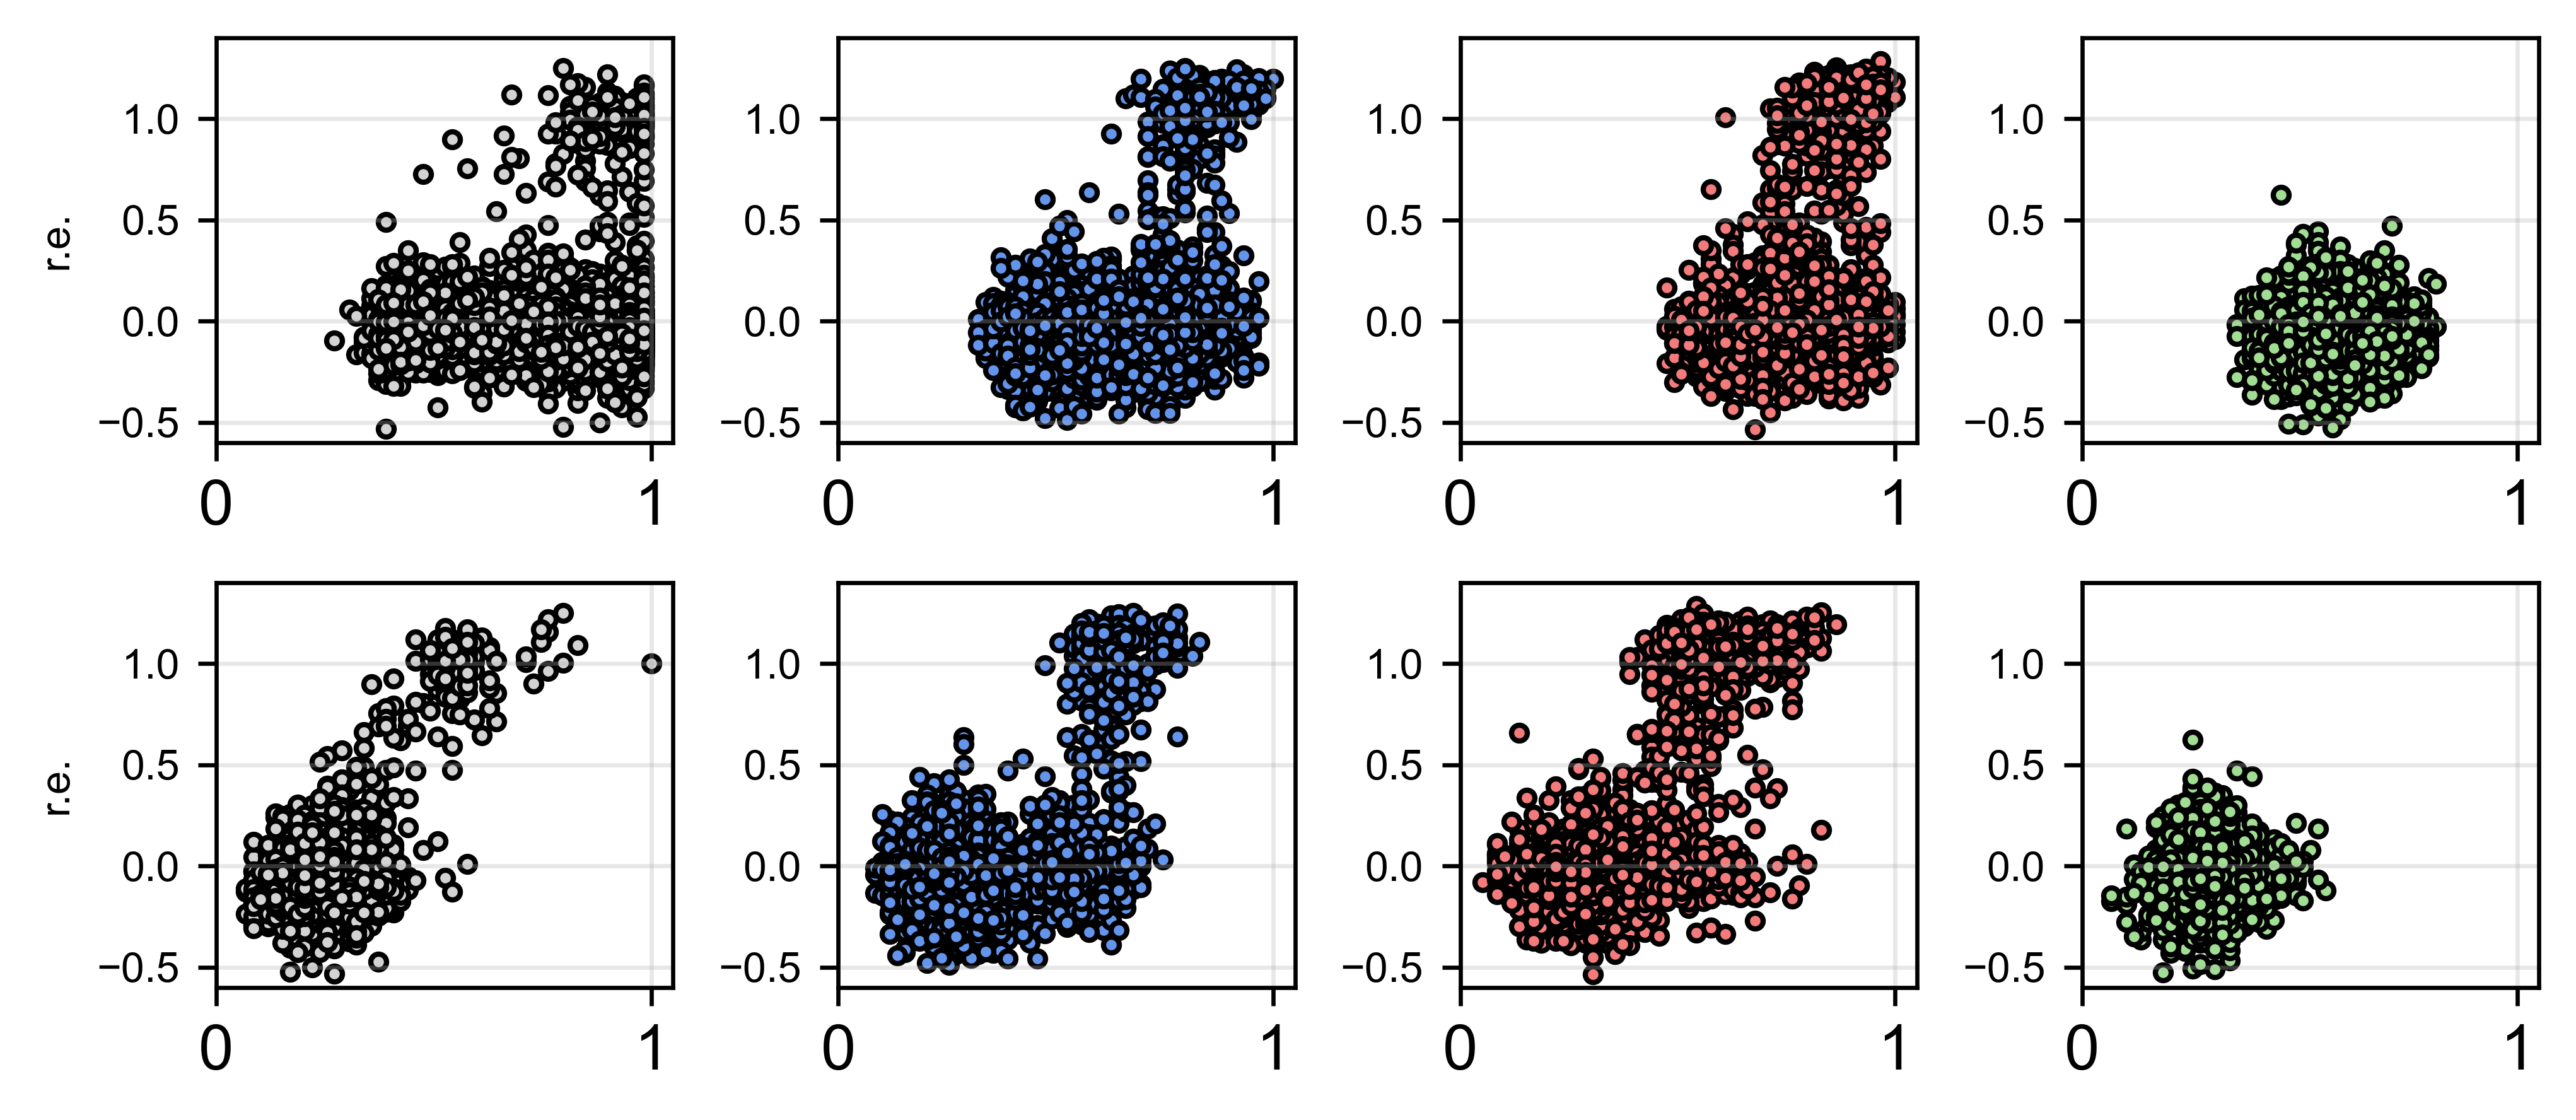

In [44]:
plt.rcParams.update({'font.family': 'Arial'})
plt.rcParams.update({'font.size': 8})
fig, ax = plt.subplots(2,4,figsize = [6.85,3],dpi=600)
for i in range(2):
    for j in range(4):
        ax[i,j].grid(alpha=.3)
        ax[i,j].scatter(id_list[i][j],re_id_list[i][j],edgecolor='k',s=9, c = clist[i][j])
        ax[i,j].set_xlim([.0, 1.05])
        ax[i,j].set_ylim([-.6, 1.4])
        #ax[0,1].set_xlabel('sequence ID to nearest natural SH3')
        #ax[1,1].set_xlabel('sequence ID to $S. Cerevisiae$ $Sho1^{SH3}$')
    ax[i,0].set_ylabel('r.e.')
plt.tight_layout()

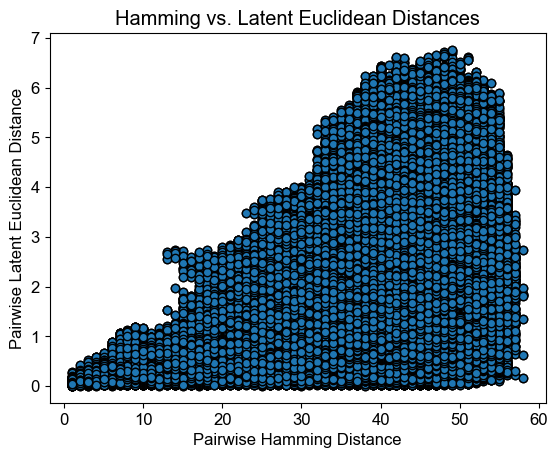

In [11]:
# Plot Hamming vs. Euclidean distances
plt.scatter(hamming_no_diag, pairwise_euclidean, edgecolor = 'k')
plt.xlabel("Pairwise Hamming Distance")
plt.ylabel("Pairwise Latent Euclidean Distance")
plt.title("Hamming vs. Latent Euclidean Distances")
#plt.savefig('response/Hamming_Euclidean.png')
plt.show()